In [1]:
#! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vx954Rp00sKJpmcXhiBYl3tF3VFrXsuW" -O CCLE_hg38_agg_050323.tar.gz && rm -rf /tmp/cookies.txt

--2023-05-31 22:48:49--  https://docs.google.com/uc?export=download&confirm=&id=1vx954Rp00sKJpmcXhiBYl3tF3VFrXsuW
Resolving docs.google.com (docs.google.com)... 142.250.72.142, 2607:f8b0:4007:815::200e
Connecting to docs.google.com (docs.google.com)|142.250.72.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2gphpjpqk7j88ppq2kj3aeusnv9ug311/1685573325000/17211967411599539974/*/1vx954Rp00sKJpmcXhiBYl3tF3VFrXsuW?e=download&uuid=0569de6a-488a-4b48-990d-97bb8d497544 [following]
--2023-05-31 22:48:49--  https://doc-08-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2gphpjpqk7j88ppq2kj3aeusnv9ug311/1685573325000/17211967411599539974/*/1vx954Rp00sKJpmcXhiBYl3tF3VFrXsuW?e=download&uuid=0569de6a-488a-4b48-990d-97bb8d497544
Resolving doc-08-94-docs.googleusercontent.com (doc-08-94-docs.googleusercontent.com)... 142.250.189.1, 2607:f8b0:400

In [2]:
#! tar -xvif CCLE_hg38_agg_050323.tar.gz 

./results/aggregated_results.csv
./results/run.json
./results/aggregated_results.html
./results/AA_outputs/HT29_LARGE_INTESTINE/run_PAA_stdout.txt
./results/AA_outputs/HT29_LARGE_INTESTINE/HT29_LARGE_INTESTINE_timing_log.txt
./results/AA_outputs/HT29_LARGE_INTESTINE/HT29_LARGE_INTESTINE_cnvkit_output.tar.gz
./results/AA_outputs/HT29_LARGE_INTESTINE/run_AA_stdout.txt
./results/AA_outputs/HT29_LARGE_INTESTINE/HT29_LARGE_INTESTINE_AA_CNV_SEEDS.bed
./results/AA_outputs/HT29_LARGE_INTESTINE/HT29_LARGE_INTESTINE_run_aa_ac.sb
./results/AA_outputs/HT29_LARGE_INTESTINE/run_PAA_stderr.txt
./results/AA_outputs/HT29_LARGE_INTESTINE/HT29_LARGE_INTESTINE_aln_stage.stderr
./results/AA_outputs/HT29_LARGE_INTESTINE/HT29_LARGE_INTESTINE_AA_results.tar.gz
./results/AA_outputs/HT29_LARGE_INTESTINE/HT29_LARGE_INTESTINE_run_PAA.sb
./results/AA_outputs/HT29_LARGE_INTESTINE/run_AA_stderr.txt
./results/AA_outputs/HT29_LARGE_INTESTINE/output/docker_home_manifest.log
./results/AA_outputs/A375_SKIN/A375_SKIN_timi

In [ ]:
# STEP 1
# Goal: Reading the CSV File, Find ecDNA in the CSV File => list of cycle files name

# Imports
import pandas as pd

# Variables
filePath = "./results/"
fileName = "aggregated_results.csv"
suffixOfCycleFileName = "_annotated_cycles.txt"
cycleFileNames = []

# Filters rows that have the classification 'ecDNA'
dataTable = pd.read_csv(filePath + fileName)
dataTable = dataTable[dataTable['Classification'].notna()]
dataTable = dataTable[dataTable['Classification'].str.contains('ecDNA')]

dataTable = dataTable['Feature ID']

# Makes a list of cycle file names
for id in dataTable:
    index = id.index('amplicon')
    cycleFileNames.append(id[:index+9] + suffixOfCycleFileName)

print(cycleFileNames)# STEP 1
# Goal: Reading the CSV File, Find ecDNA in the CSV File => list of cycle files name

# Imports
import pandas as pd

# Variables
filePath = "./results/"
fileName = "aggregated_results.csv"
suffixOfCycleFileName = "_annotated_cycles.txt"
cycleFileNames = set()

# Filters rows that have the classification 'ecDNA'
dataTable = pd.read_csv(filePath + fileName)
dataTable = dataTable[dataTable['Classification'].notna()]
dataTable = dataTable[dataTable['Classification'].str.contains('ecDNA')]

dataTable = dataTable['Feature ID']

# Makes a list of cycle file names
for id in dataTable:
    index = id.index('amplicon')
    cycleFileNames.add(id[:index+9] + suffixOfCycleFileName)

print(cycleFileNames)

In [ ]:
# STEP 2
# Goal: Open the Feature ID under cycles.txt file, find the cycles in corresponding cycles.txt file 
# => file with segments & only actual cycle content

segment_list = []

for file_name in cycleFileNames:
    sample_name = file_name.split('_')[0]
    path = f'./results/other_files/ccle_hg38_ac/ccle_hg38_annotated_cycles_files/{file_name}'

    with open(path) as file:

        # skip lines until cycle info 
        file.readline() # skip title 
        line = file.readline()
        while line[0] == 'S':
            line = file.readline()
        
        # find segments for cycles
        segments = set()
        while line:
            sep_line = line.split(';')
            cyclic = sep_line[3]
            cyclic_bool = cyclic.split('=')[1]
            if cyclic_bool == 'True':
                cycle_segments = sep_line[-1].split('=')[1]
                cycle_segments = cycle_segments.split(',')
                for i in range(len(cycle_segments)):
                    cycle_segments[i] = cycle_segments[i].strip('+-\n')
                for seg in cycle_segments:
                    segments.add(seg)
            line = file.readline()

        # identify chr positions for cyclic segments 
        file.seek(0)
        file.readline() # skip title
        line = file.readline()
        while line[0] == 'S':
            sep_line = line.strip().split('\t')
            new_line = sample_name + ',' + sep_line[2] + ',' + sep_line[3] + ',' + sep_line[4]
            if (sep_line[1] in segments) and (new_line not in segment_list):
                segment_list.append(new_line)
            line = file.readline()   

# remove repetitions
df = pd.DataFrame(columns=['sample', 'chr', 'start_pos', 'end_pos'])
for i in segment_list:
    sep_line = i.split(',')
    df.loc[len(df.index)] = [sep_line[0], sep_line[1], sep_line[2], sep_line[3]]
name = f'cyclic-segments.tsv'
df.to_csv(name, sep='\t', index=False)

In [ ]:
# STEP 3
# Goal: Check each segment to see if they are less than 1000 base pairs => file with chromosome coordinates (no repetitions)

samples = []
chromnum = []
startingcoord = []
endingcoord = []

with open ('cyclic-segments.tsv') as file:
    file.readline() # skip header
    for line in file:
        l = line.strip()
        t = l.split('\t')
        samples.append(t[0])
        chromnum.append(t[1])
        startingcoord.append(int(t[2]))
        endingcoord.append(int(t[3]))

df = pd.DataFrame(columns=['sample', 'chr', 'start_pos', 'end_pos'])
for i in range(len(startingcoord)):
    if ((endingcoord[i]-startingcoord[i]) < 1000):
        df.loc[len(df.index)] = [samples[i], chromnum[i], startingcoord[i], endingcoord[i]]
name = f'slivers.tsv'
df.to_csv(name, sep='\t', index=False, header=False)

In [ ]:
# this file will download fg38 ref genome sequence by chromosome number
# unzip files based on user input file on marker of sliver sequence
# reference: https://gist.github.com/kstreepy/a9800804c21367d5a8bde692318a18f5

import os, gzip, shutil
import requests
import pandas as pd


# this function will return DNA sequence based on the marker file
# marker file format example: Chr7 1 9

# this function will create dictionary of mapping chr number to chr filename
def constructDict():
    chr_name = []
    # generate chromosome names
    for i in range(1, 23, 1):
        chr_name.append(str(i))
    chr_name.append('MT')
    chr_name.append('X')
    chr_name.append('Y')

    # intialize chromosome dict
    chr_seq_dict = {}
    for name in chr_name:
        chr_seq_dict[name] = 'hg38.chr{}.fa.gz'.format(name)
    return chr_name, chr_seq_dict

# construct name and dictionary for mapping chromosome number to filename 
chr_name, chr_seq_dict = constructDict()
# this function will download reference human genome file to current directory
def downloadGenome():
    for name in chr_name:
        url = 'https://ftp.ensembl.org/pub/release-109/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.{}.fa.gz'.format(name)
        r = requests.get(url, allow_redirects=True)
        # same the ref genome in fasta format
        filename =  chr_seq_dict[name]
        open(filename, 'wb').write(r.content)



#uncomment to download genome files *YOU ONLY NEED TO DO IT ONCE*
#downloadGenome() # ONCE YOU FINISH, COMMENT IT OUT

# used to test functions 
#findSliverSeq('test/example.txt')
#findSliverSeq('test/ex2.txt')

In [3]:

# this function will create dictionary of mapping chr number to chr filename
def constructDict():
    chr_name = []
    # generate chromosome names
    for i in range(1, 23, 1):
        chr_name.append(str(i))
    chr_name.append('MT')
    chr_name.append('X')
    chr_name.append('Y')

    # intialize chromosome dict
    chr_seq_dict = {}
    for name in chr_name:
        chr_seq_dict[name] = 'Homo_sapiens.GRCh38.dna.chromosome.{}.fa.gz'.format(name)
    return chr_name, chr_seq_dict

# construct name and dictionary for mapping chromosome number to filename 
chr_name, chr_seq_dict = constructDict()
chr_seq_dict

{'1': 'Homo_sapiens.GRCh38.dna.chromosome.1.fa.gz',
 '2': 'Homo_sapiens.GRCh38.dna.chromosome.2.fa.gz',
 '3': 'Homo_sapiens.GRCh38.dna.chromosome.3.fa.gz',
 '4': 'Homo_sapiens.GRCh38.dna.chromosome.4.fa.gz',
 '5': 'Homo_sapiens.GRCh38.dna.chromosome.5.fa.gz',
 '6': 'Homo_sapiens.GRCh38.dna.chromosome.6.fa.gz',
 '7': 'Homo_sapiens.GRCh38.dna.chromosome.7.fa.gz',
 '8': 'Homo_sapiens.GRCh38.dna.chromosome.8.fa.gz',
 '9': 'Homo_sapiens.GRCh38.dna.chromosome.9.fa.gz',
 '10': 'Homo_sapiens.GRCh38.dna.chromosome.10.fa.gz',
 '11': 'Homo_sapiens.GRCh38.dna.chromosome.11.fa.gz',
 '12': 'Homo_sapiens.GRCh38.dna.chromosome.12.fa.gz',
 '13': 'Homo_sapiens.GRCh38.dna.chromosome.13.fa.gz',
 '14': 'Homo_sapiens.GRCh38.dna.chromosome.14.fa.gz',
 '15': 'Homo_sapiens.GRCh38.dna.chromosome.15.fa.gz',
 '16': 'Homo_sapiens.GRCh38.dna.chromosome.16.fa.gz',
 '17': 'Homo_sapiens.GRCh38.dna.chromosome.17.fa.gz',
 '18': 'Homo_sapiens.GRCh38.dna.chromosome.18.fa.gz',
 '19': 'Homo_sapiens.GRCh38.dna.chromosome.19.

In [ ]:
links = open('links.txt', 'w')
for name in chr_name:
        url = 'https://ftp.ensembl.org/pub/release-109/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.{}.fa.gz\n'.format(name)
        links.write(url)
links.close()

In [9]:
#! chmod 777 download.sh
#! ./download.sh


--2023-05-31 22:50:11--  https://ftp.ensembl.org/pub/release-109/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.1.fa.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.139
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69273468 (66M) [application/x-gzip]
Saving to: ‘Homo_sapiens.GRCh38.dna.chromosome.1.fa.gz’

Homo_sapiens.GRCh38 100%[===================>]  66.06M   351KB/s    in 2m 48s  

2023-05-31 22:52:59 (403 KB/s) - ‘Homo_sapiens.GRCh38.dna.chromosome.1.fa.gz’ saved [69273468/69273468]

--2023-05-31 22:52:59--  https://ftp.ensembl.org/pub/release-109/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.2.fa.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.139
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72794281 (69M) [application/x-gzip]
Saving to: ‘Homo_sapiens.

In [4]:
import os, gzip, shutil
import requests
import pandas as pd

def findSliverSeq(marker_file):
    markers = open(marker_file).readlines()
    result_seqs = []

    # record information about sliver seq to write to csv file later 
    gene_header = []
    chr_header = []
    start_pos = []
    end_pos = []

    for marker in markers:
        marker_list = marker.strip().split('\t')

        # record info on input file to output to df later
        gene_header.append(marker_list[0])
        chr_header.append(marker_list[1])
        start_pos.append(int(marker_list[2]))
        end_pos.append(int(marker_list[3]))

        # find actual sliver sequences 
        chr_num = marker_list[1].replace('chr', '')
        start = int(marker_list[2])
        length = int(marker_list[3]) - start + 1

        # fetch gzip file name from dict
        gzip_file = chr_seq_dict[chr_num]
        # unzipped file name no longer have gz extension (remove.gz at end)
        filename = gzip_file[:-3]
        # unzip corresponding file if it have not been unziped
        if (os.path.exists(gzip_file)):
            # unzip the file 
            with gzip.open(gzip_file,"rb") as f_in, open(filename,"wb") as f_out:
              shutil.copyfileobj(f_in, f_out)
            # remove zipped files 
            os.remove(gzip_file)

        # if it is already unzipped read in contents and find sequence
        # ignore header, read in sequences of chromosome
        chr_seq = open(filename).readlines()[1:]
        # our seq have 60 char per line
        # so we can calculate rough start line num 
        start_line_num = int(start / 60)
        # start_line_index refers on start index on start_line 
        start_line_index = start - start_line_num * 60

        # read in first line of sliver_seq based on start index
        if (start_line_index >= 0):
            if (length >= 60):
                sliver_seq = chr_seq[start_line_num].strip()[start_line_index:]
            # if length < 60, only read part of start line 
            else:
                sliver_seq = chr_seq[start_line_num].strip()[start_line_index:start_line_index+length]
        else:
            sliver_seq = chr_seq[start_line_num].strip()[start_line_index]
    
        # remaining = rest # of base to read
        remaining = length - len(sliver_seq)
        # update curr line number to read 
        curr_line_index = start_line_num + 1
        # while reamaining >= 60 char, read whole lines
        while(remaining >= 60):
            curr_seq = chr_seq[curr_line_index].strip()
            sliver_seq = sliver_seq + curr_seq
            curr_line_index+=1
            remaining = remaining - 60
        
        # if there is still sth to read after reading whole lines
        if (remaining > 0):
            # read the last sequences to sliver_seq
            sliver_seq = sliver_seq + chr_seq[curr_line_index].strip()[:remaining]
        result_seqs.append(sliver_seq)
    print(result_seqs)

    # append all result sequences to a text file line by line 
    # format like: 
    # ACTCTCTC
    # AACTTTTCCCC
    output = ''
    for sliver_seq in result_seqs:
        output = output + sliver_seq + '\n'
    
    # open result file and write to result file with all sliver seuqneces 
    with open('final_slivers.txt', 'w') as result_file:
        result_file.write(output)
    result_file.close()

    # open a csv file for storing all info about sliver sequence found 
    # cotains chromosome pos and actual sliver sequnce 
    df = pd.DataFrame()
    df['LOC'] = gene_header
    df['Chromosome Position'] = chr_header
    df['Start Position'] = start_pos
    df['End Position'] = end_pos
    df['Sequence'] = result_seqs
    df.to_csv('final_slivers.csv', index=False)

    return result_seqs

In [5]:
findSliverSeq('slivers.tsv')

['ATAATCTGTGTATTCTTTCTTTTTTAGTCTT', 'CAGGGGAAACAACCTCTCGTTCTTGAGCCTCCACCGTGCTCAGGGGAAACACGTCTCATCTATGAGTCTCCACTGTGCTCAGGGGAAACACCTCTCATCTATGAGCCTCCACCATGCTCAGGGGAAACATCTCTCGTCTATGAGCCTCCACCATGCTCAGGGGAAACACGTCTCATCTATGAGCCTCCACCGTGCTCAGGGGAAACACCTCTCGTCTATGAGCCTCCACCGTGCTCAGGGGAAACACCTCTCGCCTATGAGCCTCCACCACGCTCAGGGGAAAGACCTCTCATCTGTGAGCCTCCACCGTGATCAGGGGAAACACCTCTCATCCTTGTGCCTCCACCATGCTCAGGAGAAACACCTCTCGCCTGTGAGCCTCCACCATGCTCAGGGGAAAGACCTCTCGCCTGTGAGCCTCCACCGTGCTCAGGGAAACATCTCTCTTCCTTGCATCTCCACCGTGCTCAGGGGAAACACCTCTCGTCTATGAGCCTCCACCGTGCTCAGGGGAAACACCTCTCATCTGTGAGCCTCC', 'GCGCCTCCACCGTGCTCAGGGGAAAGACCTCTCGCCTGTGAGCCTCCACCATGCTCAGTGGAAACACCTCTCATCTGTAAGCCTCCACCGTGCTCAGGGAAACATCTCTCTTCCTTGCATCTCCACCGTGCTCAGGGGAAACACCTCTCGTCTATGAGCCTCCACCGTGCTCAGGG', 'AAGGTCGACATTTGCTGATTTTCATTATGCAGTGTTCTTTTGGGGAGCCACCCCATATTTTGCGGGCATGAGGCACTTCAGGGCCCAGTGCTGCTTCTCCAGTGGCCACTGGGAGAAGAGCTGGGCAGAGCGAGCCATTTCCGCACCAGCTGGAGCCAGGCAGAGGGCTCCGCGGCCTCTCCCGACCCTGTGCCACCAACTGTAGGAGGCCTCCAAGTGCAGGATGCGCAGGCAGGAGGGG

['ATAATCTGTGTATTCTTTCTTTTTTAGTCTT',
 'CAGGGGAAACAACCTCTCGTTCTTGAGCCTCCACCGTGCTCAGGGGAAACACGTCTCATCTATGAGTCTCCACTGTGCTCAGGGGAAACACCTCTCATCTATGAGCCTCCACCATGCTCAGGGGAAACATCTCTCGTCTATGAGCCTCCACCATGCTCAGGGGAAACACGTCTCATCTATGAGCCTCCACCGTGCTCAGGGGAAACACCTCTCGTCTATGAGCCTCCACCGTGCTCAGGGGAAACACCTCTCGCCTATGAGCCTCCACCACGCTCAGGGGAAAGACCTCTCATCTGTGAGCCTCCACCGTGATCAGGGGAAACACCTCTCATCCTTGTGCCTCCACCATGCTCAGGAGAAACACCTCTCGCCTGTGAGCCTCCACCATGCTCAGGGGAAAGACCTCTCGCCTGTGAGCCTCCACCGTGCTCAGGGAAACATCTCTCTTCCTTGCATCTCCACCGTGCTCAGGGGAAACACCTCTCGTCTATGAGCCTCCACCGTGCTCAGGGGAAACACCTCTCATCTGTGAGCCTCC',
 'GCGCCTCCACCGTGCTCAGGGGAAAGACCTCTCGCCTGTGAGCCTCCACCATGCTCAGTGGAAACACCTCTCATCTGTAAGCCTCCACCGTGCTCAGGGAAACATCTCTCTTCCTTGCATCTCCACCGTGCTCAGGGGAAACACCTCTCGTCTATGAGCCTCCACCGTGCTCAGGG',
 'AAGGTCGACATTTGCTGATTTTCATTATGCAGTGTTCTTTTGGGGAGCCACCCCATATTTTGCGGGCATGAGGCACTTCAGGGCCCAGTGCTGCTTCTCCAGTGGCCACTGGGAGAAGAGCTGGGCAGAGCGAGCCATTTCCGCACCAGCTGGAGCCAGGCAGAGGGCTCCGCGGCCTCTCCCGACCCTGTGCCACCAACTGTAGGAGGCCTCCAAGTGCAGGATGCGCAGGCAGGAG

## Analyze 

In [6]:
import pandas as pd
import seaborn as sns 

sliver_df = pd.read_csv('final_slivers.csv')
sliver_df


,LOC,Chromosome Position,Start Position,End Position,Sequence
0,NCIH1437,chr5,614072,614102,ATAATCTGTGTATTCTTTCTTTTTTAGTCTT
1,NCIH1437,chr5,754051,754588,CAGGGGAAACAACCTCTCGTTCTTGAGCCTCCACCGTGCTCAGGGG...
2,NCIH1437,chr5,846904,847079,GCGCCTCCACCGTGCTCAGGGGAAAGACCTCTCGCCTGTGAGCCTC...
3,NCIH1437,chr5,1217455,1218281,AAGGTCGACATTTGCTGATTTTCATTATGCAGTGTTCTTTTGGGGA...
4,NCIH1437,chr5,3323615,3324307,GTTGTGTGCGTGGTGTGTGATGCAGGTGGTGTGTGATGTGTGGCGT...
...,...,...,...,...,...
674,NCIH2171,chr12,28575923,28576355,ATGAGTCAATAGGAAATCCACCCAAACAGGTTAAAATTAAAACTGA...
675,NCIH2171,chr12,28801411,28801968,TTCAAGGAACTTTGAGAGCAGTAACCCTTAAGGCTCAAGTTCATCA...
676,NCIH2171,chr13,22549543,22549548,ATGGGT
677,NCIH2171,chr13,57620658,57620812,ATCATCTTTGAATTTCACATGTCGGGGGAATATGTCTATGTTTGTT...


In [7]:
# plot for lengths of sliver sequence
def returnLength(seq):
    return len(seq)

sliver_df['length'] = sliver_df['Sequence'].apply(returnLength)
sliver_df

,LOC,Chromosome Position,Start Position,End Position,Sequence,length
0,NCIH1437,chr5,614072,614102,ATAATCTGTGTATTCTTTCTTTTTTAGTCTT,31
1,NCIH1437,chr5,754051,754588,CAGGGGAAACAACCTCTCGTTCTTGAGCCTCCACCGTGCTCAGGGG...,538
2,NCIH1437,chr5,846904,847079,GCGCCTCCACCGTGCTCAGGGGAAAGACCTCTCGCCTGTGAGCCTC...,176
3,NCIH1437,chr5,1217455,1218281,AAGGTCGACATTTGCTGATTTTCATTATGCAGTGTTCTTTTGGGGA...,827
4,NCIH1437,chr5,3323615,3324307,GTTGTGTGCGTGGTGTGTGATGCAGGTGGTGTGTGATGTGTGGCGT...,693
...,...,...,...,...,...,...
674,NCIH2171,chr12,28575923,28576355,ATGAGTCAATAGGAAATCCACCCAAACAGGTTAAAATTAAAACTGA...,433
675,NCIH2171,chr12,28801411,28801968,TTCAAGGAACTTTGAGAGCAGTAACCCTTAAGGCTCAAGTTCATCA...,558
676,NCIH2171,chr13,22549543,22549548,ATGGGT,6
677,NCIH2171,chr13,57620658,57620812,ATCATCTTTGAATTTCACATGTCGGGGGAATATGTCTATGTTTGTT...,155


## analyze distribution of length of sliver sequences 

<AxesSubplot:xlabel='length', ylabel='Count'>

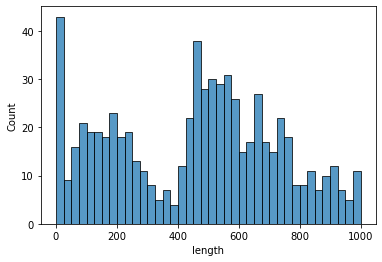

In [8]:
sns.histplot(data =sliver_df, x='length', bins=40)

In [9]:
sliver_df.describe()

,Start Position,End Position,length
count,6.790000e+02,6.790000e+02,679.000000
mean,7.582966e+07,7.583011e+07,454.075110
std,4.680114e+07,4.680115e+07,270.320413
min,4.985900e+05,4.992390e+05,1.000000
25%,3.801698e+07,3.801755e+07,202.000000
50%,7.070573e+07,7.070646e+07,483.000000
75%,1.070874e+08,1.070882e+08,658.000000
max,2.434603e+08,2.434608e+08,999.000000


In [10]:
# take a look at small sequences that highest count among all other groups 
small_sliver = sliver_df[sliver_df['length'] < 40]
print(small_sliver.shape[0])
small_sliver

46


,LOC,Chromosome Position,Start Position,End Position,Sequence,length
0,NCIH1437,chr5,614072,614102,ATAATCTGTGTATTCTTTCTTTTTTAGTCTT,31
26,REC1,chr2,16225124,16225141,AGGGAACTGCTGGAAGCC,18
30,REC1,chr3,56731592,56731609,CGGGTTTTAAGTTTTCTT,18
31,REC1,chr3,188011100,188011107,TAAAAATC,8
35,REC1,chr5,55569955,55569972,AAAAAATATTAACTTGCC,18
37,REC1,chr5,144135482,144135488,TTATAGG,7
41,REC1,chr7,52957923,52957925,TGG,3
43,REC1,chr7,73967763,73967788,ATCCTCATCTCCGTTCTTACCTCCAC,26
53,REC1,chr11,63931434,63931436,CAG,3
62,59M,chr11,38791107,38791118,ATAACAATTTTT,12


In [11]:
# we can find that those 
small_sliver_groups = small_sliver.groupby(['LOC']).count()[['length']]
small_sliver_groups.columns = ['count']
small_sliver_groups

,count
LOC,
59M,1
BT20,1
CALU6,1
DMS273,1
EFM19,1
EFM192A,1
HCC1419,2
HCC202,1
HCC95,1


In [12]:
# we found that OE19 amd UACC812 has many small sliver sequences 
small_sliver_groups[small_sliver_groups['count'] > 1].sort_values(by='count', ascending=False)

,count
LOC,
REC1,8
UACC812,5
MKN45,4
OE19,3
TE1,3
HCC1419,2
NCIH1184,2
NCIH1435,2


In [13]:
small_sliver_groups_2 = small_sliver.groupby(['LOC','Chromosome Position']).count()[['length']]
small_sliver_groups_2.columns = ['count']
small_sliver_groups_2

count
LOC      Chromosome Position       
59M      chr11                    1
BT20     chr12                    1
CALU6    chr11                    1
DMS273   chr1                     1
EFM19    chr10                    1
EFM192A  chr8                     1
HCC1419  chr11                    1
         chr20                    1
HCC202   chrX                     1
HCC95    chr11                    1
HS746T   chr7                     1
MKN45    chr11                    3
         chr7                     1
NCIH1184 chr1                     2
NCIH1435 chr11                    2
NCIH1437 chr5                     1
NCIH1651 chr19                    1
NCIH2171 chr13                    1
NCIH3255 chr7                     1
NCIH510  chr8                     1
NCIH526  chr2                     1
OE19     chr17                    3
REC1     chr11                    1
         chr2                     1
         chr3                     2
         chr5                     2
         chr7                     2
SCLC21H  chr1                     1
TE1      chr11                    3
UACC812  chr1                     1
         chr13                    1
         chr20                    3
UACC893  chrX                     1

In [14]:
small_sliver_groups_2[small_sliver_groups_2['count'] > 1].sort_values(by='count', ascending=False)

count
LOC      Chromosome Position       
MKN45    chr11                    3
OE19     chr17                    3
TE1      chr11                    3
UACC812  chr20                    3
NCIH1184 chr1                     2
NCIH1435 chr11                    2
REC1     chr3                     2
         chr5                     2
         chr7                     2

In [15]:
loc_small = small_sliver_groups[small_sliver_groups['count'] > 1].sort_values(by='count', ascending=False).index
loc_small

Index(['REC1', 'UACC812', 'MKN45', 'OE19', 'TE1', 'HCC1419', 'NCIH1184',
       'NCIH1435'],
      dtype='object', name='LOC')

In [16]:
# we also want to take a look at those with only 1 nucleotide sliver sequence
one_sliver = small_sliver[small_sliver['length'] == 1]
loc_one = one_sliver.index
one_sliver

,LOC,Chromosome Position,Start Position,End Position,Sequence,length
191,DMS273,chr1,151245645,151245645,C,1
628,NCIH1435,chr11,79175804,79175804,A,1


Therefore, we'd also like to take a look at NCIH1435 as it has 2 small sequence and one with one nucleotide, as well as for DMS273

In [17]:
# let's take a look at largest sequence too
large_sliver = sliver_df[sliver_df['length'] > 950].sort_values(by='length', ascending=False)
large_sliver

,LOC,Chromosome Position,Start Position,End Position,Sequence,length
150,UACC812,chrX,89204167,89205165,AGGTGTCGTGAAATACCAACGTATATCTTATATTCGTAGGTGTCGT...,999
306,NCIH510,chr8,104317764,104318761,CTCCTGAGCACTTAGGGATTATAGAAACTATGTCTACATTTTAGCA...,998
120,EFM19,chr10,89016947,89017943,ATTTTTTTCTATGCTTACTCCTGATTGGTAATTTGTTTGGGTTTAG...,997
63,MKN1,chr12,25590144,25591139,CCACTGAAAAGGTAGGATAAACAGTCTTTAGTCACTGACACCAACC...,996
133,HCC44,chr8,127580333,127581327,CTGTGAAAAAGTTTGGCAGTTCCTCATTAGAAGTTATCATGTGATC...,995
396,GI1,chr3,195944168,195945156,TAAATCTAGAACATCAGCTCCTCCCTGAGTCTCCAACTGAAAGACC...,989
136,HCC44,chr8,127641367,127642353,AAAACAGAAGGATAGATAATACTTGCAAAACATTGATAATTATGAA...,987
463,NCIH446,chr8,127827446,127828432,CCCTGTATAGGGGAGCCATCAGCCTGACTGAGCAGCCCTGAGGCTG...,987
316,NCIH510,chr8,107529357,107530341,CTGCTGGGTTTTACTCATTCAACTAAACAATTGTGAAAGGTCTACA...,985
416,GCIY,chr8,101554633,101555611,ATTCATGAATTAAGTTGCTATATGTTAATATAGTATCATTACAACT...,979


In [18]:
largest = large_sliver.iloc[0]
largest

LOC                                                              UACC812
Chromosome Position                                                 chrX
Start Position                                                  89204167
End Position                                                    89205165
Sequence               AGGTGTCGTGAAATACCAACGTATATCTTATATTCGTAGGTGTCGT...
length                                                               999
Name: 150, dtype: object

In [19]:
large_sliver.groupby(['LOC', 'Chromosome Position']).count()

,,Start Position,End Position,Sequence,length
LOC,Chromosome Position,,,,
EFM19,chr10,1,1,1,1
EFM192A,chr20,1,1,1,1
GCIY,chr8,1,1,1,1
GI1,chr3,1,1,1,1
HCC44,chr8,2,2,2,2
MKN1,chr12,1,1,1,1
NCIH1694,chr1,1,1,1,1
NCIH2066,chr5,1,1,1,1
NCIH2122,chr8,1,1,1,1


In [20]:
large_sliver.groupby(['Chromosome Position'])[['length']].mean().sort_values(by='length', ascending=False).head()

,length
Chromosome Position,
chr10,997.000000
chr3,989.000000
chr8,986.714286
chrX,981.500000
chr12,977.500000


In [21]:
# take a look at small sequences that highest count among all other groups 
sliver_df.groupby('Chromosome Position').mean()[['length']].sort_values(by='length', ascending=False).head()

/tmp/ipykernel_117/201828524.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sliver_df.groupby('Chromosome Position').mean()[['length']].sort_values(by='length', ascending=False).head()


,length
Chromosome Position,
chr14,575.045455
chr4,552.125000
chrX,533.050000
chr6,519.250000
chr8,507.098592


In [22]:
sliver_df.groupby('LOC').count()[['length']].sort_values(by='length', ascending=False).head()

,length
LOC,
NCIH510,98
REC1,34
EFM192A,28
SNU475,28
NCIH2171,24


In [23]:
sliver_df.groupby('Chromosome Position').count()[['length']].sort_values(by='length', ascending=False).head()

,length
Chromosome Position,
chr8,142
chr11,101
chr1,99
chr10,59
chr5,38


<AxesSubplot:xlabel='count', ylabel='Chromosome Position'>

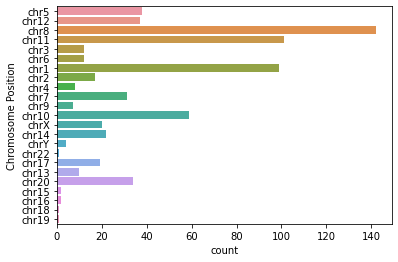

In [24]:
sns.countplot(data =sliver_df, y='Chromosome Position')

In [25]:
# omiited chromosome:
included_chromosome = sliver_df.groupby('Chromosome Position').count().index
print(included_chromosome)
print(len(included_chromosome))

print("It is missing Chromosome 21 and Chromosome MT")

Index(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
       'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr22', 'chr3', 'chr4',
       'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX', 'chrY'],
      dtype='object', name='Chromosome Position')
23
It is missing Chromosome 21 and Chromosome MT


In [26]:
sliver_df.Sequence.value_counts()

GATATTGCACCACTGCACTCCAGCCTGGGCATCAGAGCGAGACTCCGTCTCAAAAAAGACAAGACAAGAAAAGAAATTTCTAGGCCGGGCGTGGTGGCTCATGCCTGTAATCCCAGCACTTTGGGAGGCTGAGGCGGGTGGATCACGAGATCAGGAGTTCAATACCAGCCTGGCCAAGATGGTGAAACCCTGTCTCTACTAAAAATACAAAAACATTAGCCAGGCATGGTGGCGGGTGCCTGTAATCCCAGCTACTGGGAAGGCTGAGGCAGAGAATTGCTTGAACCCAGG                                                                                                                                      2
CC                                                                                                                                                                                                                                                                                                                                                                                                                                       2
ATAACAATTTTT                                                                                                                                      

In [27]:
sequence_df = sliver_df.groupby('Sequence').count()[['length']]
sequence_df.columns = ['count']
sequence_df = sequence_df.reset_index().sort_values('count', ascending=False)
sequence_df[sequence_df['count'] > 1]

,Sequence,count
211,CACATAGCATATGTCATCAGGGAATTGTAAACTCAAGTAACAGTGA...,2
150,ATAACAATTTTT,2
379,GATATTGCACCACTGCACTCCAGCCTGGGCATCAGAGCGAGACTCC...,2
217,CAG,2
237,CC,2


In [28]:
sequence_df = sliver_df.groupby(['Sequence', 'Chromosome Position']).count()[['length']]
sequence_df.columns = ['count']
sequence_df = sequence_df.reset_index().sort_values('count', ascending=False)
sequence_df[sequence_df['count'] > 1]

,Sequence,Chromosome Position,count
211,CACATAGCATATGTCATCAGGGAATTGTAAACTCAAGTAACAGTGA...,chr7,2
150,ATAACAATTTTT,chr11,2
380,GATATTGCACCACTGCACTCCAGCCTGGGCATCAGAGCGAGACTCC...,chr11,2
217,CAG,chr11,2


In [37]:
repetitive_slivers = open('repetition.txt', 'w')
for seq in sequence_df[sequence_df['count'] > 1]['Sequence']: 
    print(seq)
    repetitive_slivers.write(seq + '\n')
repetitive_slivers.close()

CACATAGCATATGTCATCAGGGAATTGTAAACTCAAGTAACAGTGAGATGCCAGTACACTCATTAGAATGACTAAAATCCCAAACACTGACATCAAATGCTGATGAGGACAGAAAGCAATGGCAACTCCCATTTATGTTGCTAGGTATTTATTAAATGAAACGAAAGCTTAGGACCACACAAAAGCCTGCTGACAATTGTTTATAGCACTTTATTCATAACTGCCAAGAATTAGGTGCAAACAAGCTGCCCATCAATAGGTAAACTGATAAACAAACTAAAGTACGTTTATATAATTGATTATCATTCAGTGATAAAGAGGAATACACTATCAAGCTACAAAA
ATAACAATTTTT
GATATTGCACCACTGCACTCCAGCCTGGGCATCAGAGCGAGACTCCGTCTCAAAAAAGACAAGACAAGAAAAGAAATTTCTAGGCCGGGCGTGGTGGCTCATGCCTGTAATCCCAGCACTTTGGGAGGCTGAGGCGGGTGGATCACGAGATCAGGAGTTCAATACCAGCCTGGCCAAGATGGTGAAACCCTGTCTCTACTAAAAATACAAAAACATTAGCCAGGCATGGTGGCGGGTGCCTGTAATCCCAGCTACTGGGAAGGCTGAGGCAGAGAATTGCTTGAACCCAGG
CAG


In [30]:
def computeAlleleFrequemcy(dna):
    counts = {'A': 0, 'T':0, 'C':0,'G':0 }
    
    total = len(dna)
    for nucle in dna:
        counts[nucle]+=1
    
    for nucle in counts.keys():
        counts[nucle] = counts[nucle] / total
        
    
    if (counts['A'] + counts['T'] - counts['C'] + counts['G'] > 0.1):
        print('More AT content detected')
                                          
    elif (counts['A'] + counts['T'] - counts['C'] + counts['G'] < -0.1):
        print('More CG content detected')
                                            
    else:
        print('around the same')
    return counts

In [31]:
sequences = sequence_df[sequence_df['count'] > 1]['Sequence'].tolist()
sequences

['CACATAGCATATGTCATCAGGGAATTGTAAACTCAAGTAACAGTGAGATGCCAGTACACTCATTAGAATGACTAAAATCCCAAACACTGACATCAAATGCTGATGAGGACAGAAAGCAATGGCAACTCCCATTTATGTTGCTAGGTATTTATTAAATGAAACGAAAGCTTAGGACCACACAAAAGCCTGCTGACAATTGTTTATAGCACTTTATTCATAACTGCCAAGAATTAGGTGCAAACAAGCTGCCCATCAATAGGTAAACTGATAAACAAACTAAAGTACGTTTATATAATTGATTATCATTCAGTGATAAAGAGGAATACACTATCAAGCTACAAAA',
 'ATAACAATTTTT',
 'GATATTGCACCACTGCACTCCAGCCTGGGCATCAGAGCGAGACTCCGTCTCAAAAAAGACAAGACAAGAAAAGAAATTTCTAGGCCGGGCGTGGTGGCTCATGCCTGTAATCCCAGCACTTTGGGAGGCTGAGGCGGGTGGATCACGAGATCAGGAGTTCAATACCAGCCTGGCCAAGATGGTGAAACCCTGTCTCTACTAAAAATACAAAAACATTAGCCAGGCATGGTGGCGGGTGCCTGTAATCCCAGCTACTGGGAAGGCTGAGGCAGAGAATTGCTTGAACCCAGG',
 'CAG']

In [32]:
for seq in sequences:
    print(computeAlleleFrequemcy(seq))

More AT content detected
{'A': 0.3965014577259475, 'T': 0.25072886297376096, 'C': 0.18658892128279883, 'G': 0.1661807580174927}
More AT content detected
{'A': 0.4166666666666667, 'T': 0.5, 'C': 0.08333333333333333, 'G': 0.0}
More AT content detected
{'A': 0.28865979381443296, 'T': 0.18900343642611683, 'C': 0.24054982817869416, 'G': 0.281786941580756}
More AT content detected
{'A': 0.3333333333333333, 'T': 0.0, 'C': 0.3333333333333333, 'G': 0.3333333333333333}


In [33]:
# overall more AT content is detected in the repetitive sequences of sliver sequence 